In [1]:
from neuprint import Client
from neuprint import NeuronCriteria as NC
from neuprint import fetch_neurons
from neuprint import fetch_adjacencies
from neuprint.utils import connection_table_to_matrix
import bokeh.palettes
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import hvplot.pandas
import holoviews as hv
import numpy as np
import pandas as pd
import ants
import nibabel as nib
import os
import pickle
import scipy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
from fa2 import ForceAtlas2
from nxviz import CircosPlot
import nxviz as nv
import tqdm
import time
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import bigbadbrain as bbb
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.colors as mcolors
import brainsss
import cv2

Loading BokehJS ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [3]:
### Load Synapses ###
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA/hemibrain_all_neurons_synapses_polypre_centrifugal_synapses.pickle'
file = open(file, 'rb')
synapses = pickle.load(file)
cell_ids = np.unique(synapses['bodyid'])

### Load Skeletons
file = "/oak/stanford/groups/trc/data/Alex/luke_list_transformed_FDA_physical.npy"
skeletons = np.load(file)
skeleton_ids = np.asarray([int(i) for i in skeletons[:,3]])

### Load FDA ###
FDA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine.nii'
FDA = np.asarray(nib.load(FDA_file).get_fdata().squeeze(), dtype='float32')
FDA = ants.from_numpy(FDA)

In [241]:
synapses

{'Label': array(['dendrite', 'dendrite', 'primary.neurite', ..., 'dendrite',
        'dendrite', 'dendrite'], dtype='<U16'),
 'bodyid': array(['5812980768', '5812980768', '5812980768', ..., '5813061760',
        '5813061760', '5813061760'], dtype='<U10'),
 'confidence': array([0.746879, 0.632528, 0.888256, ..., 0.867   , 0.867   , 0.867   ]),
 'connector_id': array([1.32260000e+08, 1.31973222e+08, 1.46044755e+08, ...,
        1.80997764e+08, 1.80997764e+08, 1.80997764e+08]),
 'inside': array(['MB(R)', 'MB(R)', 'PED(R)', ..., 'AVLP(R)', 'AVLP(R)', 'AVLP(R)'],
       dtype='<U17'),
 'old_xyz': array([[15701., 15759., 13579., ...,  9931.,  9931.,  9931.],
        [30338., 30308., 27417., ..., 27508., 27508., 27508.],
        [13665., 13544., 18716., ..., 30441., 30441., 30441.]]),
 'partner': array([9.85765545e+08, 9.54735414e+08, 9.53029783e+08, ...,
        2.16264996e+09, 2.16264960e+09, 2.16265004e+09]),
 'prepost': array([1., 1., 1., ..., 0., 0., 0.]),
 'treenode_id': array([ 261.,  

In [17]:
save_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA/peak_times_in_fda_crop.pickle"
with open(save_file, 'rb') as handle:
    peak_times_in_fda_crop = pickle.load(handle)

In [21]:
def load_FDA():
    FDA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine.nii'
    FDA = np.asarray(nib.load(FDA_file).get_fdata().squeeze(), dtype='float32')
    FDA = ants.from_numpy(FDA)
    FDA.set_spacing((.38,.38,.38))
    FDA_lowres = ants.resample_image(FDA,(2.6,2.6,5),use_voxels=False)
    return FDA, FDA_lowres

FDA, FDA_lowres = load_FDA()

In [22]:
# hemibrain bounding box
start = {'x': 46, 'y': 5, 'z': 5}
stop = {'x': 147, 'y': 89, 'z': 34}

FDA_crop = FDA_lowres[start['x']:stop['x'],
                     start['y']:stop['y'],
                     start['z']:stop['z']]

In [181]:
FDA.shape

(1652, 768, 479)

In [220]:
DN_ids = {'DNa04': 1262014782,
          'DNa03': 1139909038,
          'DNa02': 1140245595,
          'WED075': 1747625772,
          'PS100': 5813057263,
          'AOTU005': 1355115431}

In [221]:
synapse_times_all = {}
x_all = {}
y_all = {}
z_all = {}

for cell in DN_ids.keys():
    indicies = np.where(synapses['bodyid']==str(DN_ids[cell]))[0]
    x = synapses['x'][indicies]/2.6*.38 - start['x']
    y = synapses['y'][indicies]/2.6*.38 - start['y']
    z = synapses['z'][indicies]/5*.38 - start['z']
    
    x_all[cell] = x
    y_all[cell] = y
    z_all[cell] = z

    x_bins = np.digitize(x, bins=np.arange(2.6,101))
    y_bins = np.digitize(y, bins=np.arange(2.6,84))
    z_bins = np.digitize(z, bins=np.arange(5,29))

    synapse_times = []
    for i in range(len(x_bins)):
        synapse_times.append(peak_times_in_fda_crop[1][x_bins[i],y_bins[i],z_bins[i]])
    synapse_times_all[cell] = synapse_times

In [145]:
start_c = 265 ###
end_c = 200 ######## most used
middle_c = 250 ###

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle_c-end_c))
colors2 = plt.cm.Reds(np.linspace(0, 1, start_c-middle_c))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [ ]:
def draw_grid():
    for i in np.arange(0,180,30):
        plt.axvline(i,color='w')
    for i in np.arange(0,180,30):
        plt.axhline(i,color='w')

In [238]:
DN_ids.keys()

dict_keys(['DNa04', 'DNa03', 'DNa02', 'WED075', 'PS100', 'AOTU005'])

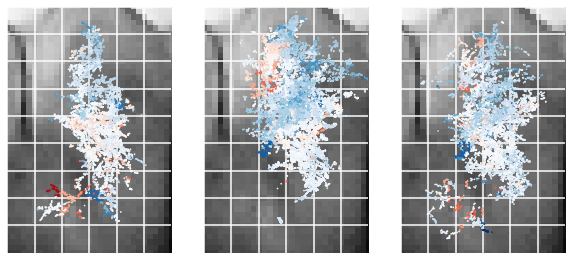

In [240]:
cell = 'DNa03'
plt.figure(figsize=(10,10))

for j,cell in enumerate(['DNa04', 'DNa03', 'DNa02']):
    plt.subplot(1,3,j+1)
    plt.imshow(FDA_crop[:,:,10].T,cmap='Greys_r',zorder=1)
    plt.scatter(x_all[cell],y_all[cell],s=.5,c=synapse_times_all[cell],cmap=mymap,vmin=end_c,vmax=start_c,zorder=3)
    plt.xlim(40,70)
    plt.ylim(80,35)
    plt.axis('off')
    for i in np.arange(40,70,5):
        plt.axvline(i,color='w')
    for i in np.arange(35,80,5):
        plt.axhline(i,color='w')

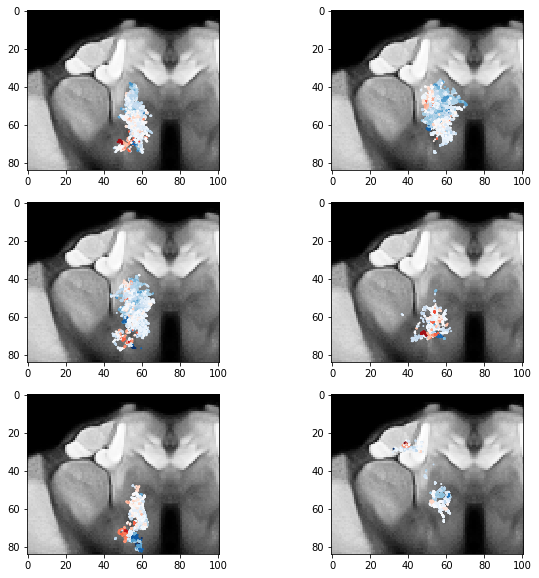

In [229]:
cell = 'DNa03'
plt.figure(figsize=(10,10))

for j,cell in enumerate(DN_ids.keys()):
    plt.subplot(3,2,j+1)
    plt.imshow(FDA_crop[:,:,10].T,cmap='Greys_r',zorder=1)
    plt.scatter(x_all[cell],y_all[cell],s=1,c=synapse_times_all[cell],cmap=mymap,vmin=end_c,vmax=start_c,zorder=3)
#     plt.xlim(40,70)
#     plt.ylim(80,35)
#     plt.axis('off')
#     for i in np.arange(40,70,5):
#         plt.axvline(i,color='w')
#     for i in np.arange(35,80,5):
#         plt.axhline(i,color='w')

ValueError: num must be 1 <= num <= 3, not 4

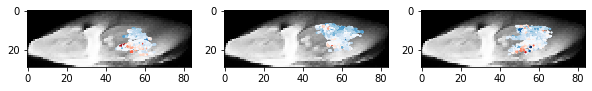

In [226]:
cell = 'DNa03'
plt.figure(figsize=(10,10))

for j,cell in enumerate(DN_ids.keys()):
    plt.subplot(1,3,j+1)
    plt.imshow(FDA_crop[40,:,:].T,cmap='Greys_r',zorder=1)
    plt.scatter(x_all[cell],z_all[cell],s=1,c=synapse_times_all[cell],cmap=mymap,vmin=end_c,vmax=start_c,zorder=3)
#     plt.xlim(40,70)
#     plt.ylim(80,35)
#     plt.axis('off')
#     for i in np.arange(40,70,5):
#         plt.axvline(i,color='w')
#     for i in np.arange(35,80,5):
#         plt.axhline(i,color='w')

(500, 300)

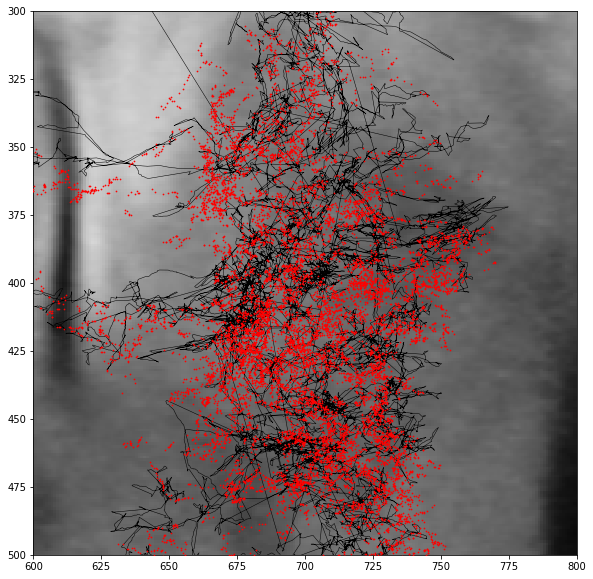

In [199]:
cell = 'DNa02'
plt.figure(figsize=(10,10))

### PLOT FDA ###
plt.imshow(FDA[:,:,200].T,cmap='Greys_r',zorder=1)

### PLOT SKELETON ###
skeleton = skeletons[np.where(ids==DN_ids[cell])[0],:3]
plt.plot(skeleton[:,0]/.38,skeleton[:,1]/.38,color='k',lw=.5,zorder=2)
    
### PLOT SYNAPSES ###
indicies = np.where(synapses['bodyid']==str(DN_ids[cell]))[0]
x = synapses['x'][indicies]
y = synapses['y'][indicies]
z = synapses['z'][indicies]
plt.scatter(x,y,color='r',s=.5,zorder=3)

plt.xlim(600,800)
plt.ylim(500,300)

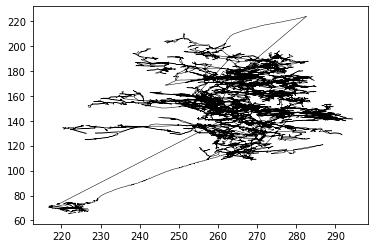

In [195]:
skeleton = skeletons[np.where(ids==DN_ids[cell])[0],:3]
plt.plot(skeleton[:,0],skeleton[:,1],color='k',lw=.5,zorder=2)

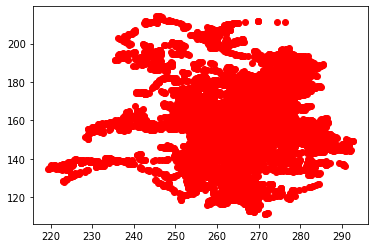

In [189]:
plt.scatter(x,y,color='r')

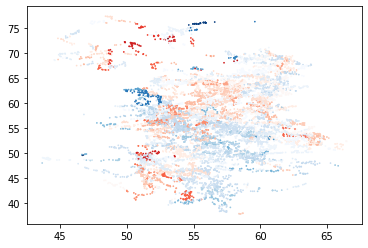

In [60]:
plt.scatter(x,y,s=.5,c=synapse_times,cmap=mymap)

In [114]:
np.arange(0,242*2.6,2.6)

array([  0. ,   2.6,   5.2,   7.8,  10.4,  13. ,  15.6,  18.2,  20.8,
        23.4,  26. ,  28.6,  31.2,  33.8,  36.4,  39. ,  41.6,  44.2,
        46.8,  49.4,  52. ,  54.6,  57.2,  59.8,  62.4,  65. ,  67.6,
        70.2,  72.8,  75.4,  78. ,  80.6,  83.2,  85.8,  88.4,  91. ,
        93.6,  96.2,  98.8, 101.4, 104. , 106.6, 109.2, 111.8, 114.4,
       117. , 119.6, 122.2, 124.8, 127.4, 130. , 132.6, 135.2, 137.8,
       140.4, 143. , 145.6, 148.2, 150.8, 153.4, 156. , 158.6, 161.2,
       163.8, 166.4, 169. , 171.6, 174.2, 176.8, 179.4, 182. , 184.6,
       187.2, 189.8, 192.4, 195. , 197.6, 200.2, 202.8, 205.4, 208. ,
       210.6, 213.2, 215.8, 218.4, 221. , 223.6, 226.2, 228.8, 231.4,
       234. , 236.6, 239.2, 241.8, 244.4, 247. , 249.6, 252.2, 254.8,
       257.4, 260. , 262.6, 265.2, 267.8, 270.4, 273. , 275.6, 278.2,
       280.8, 283.4, 286. , 288.6, 291.2, 293.8, 296.4, 299. , 301.6,
       304.2, 306.8, 309.4, 312. , 314.6, 317.2, 319.8, 322.4, 325. ,
       327.6, 330.2,

In [113]:
DN_crop.shape

(101, 84, 29)

In [97]:
idx = list(np.where(synapses['bodyid']==str(DN_ids['DNa03']))[0])

xs = synapses['x'][idx]
ys = synapses['y'][idx]
zs = synapses['z'][idx]

DN = np.histogramdd((xs*.38,ys*.38,zs*.38),
        bins=(np.arange(0,242*2.6,2.6), np.arange(0,113*2.6,2.6), np.arange(0,37*5,5)))[0]

DN_crop = DN[start['x']:stop['x'],
                  start['y']:stop['y'],
                  start['z']:stop['z']]

thresh = 1
DN_crop[DN_crop <= thresh] = np.nan
DN_crop[DN_crop>thresh] = 1

In [98]:
intersect = np.logical_and(DN_crop == 1, peak_times_in_fda_crop[1]==1).astype('int')
intersect = intersect.astype('float')
#intersect[intersect == 0] = np.nan

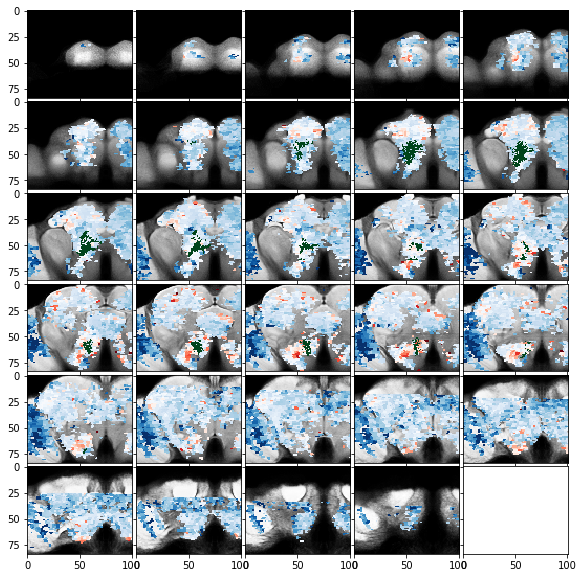

In [99]:
fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for z in range(29):
    grid[z].imshow(FDA_crop[:,:,z].T,cmap='Greys_r')
    grid[z].imshow(peak_times_in_fda_crop[1][:,:,z].T,cmap=mymap,vmin=end_c,vmax=start_c)
    grid[z].imshow(DN_crop[:,:,z].T, cmap='Greens', vmin=0, vmax=1)

    #grid[z].imshow(unique_crop_thresh[:,:,z].T, cmap='Reds', vmin=0, vmax=1)
    #grid[z].imshow(intersect[:,:,z].T, cmap='plasma', vmin=0, vmax=1)

In [234]:
idx = list(np.where(synapses['bodyid']==str(DN_ids['DNa04']))[0])

xs = synapses['x'][idx]
ys = synapses['y'][idx]
zs = synapses['z'][idx]

DN = np.histogramdd((xs*.38,ys*.38,zs*.38),
        bins=(np.arange(0,242*2.6,2.6), np.arange(0,113*2.6,2.6), np.arange(0,37*5,5)))[0]

DN_crop = DN[start['x']:stop['x'],
                  start['y']:stop['y'],
                  start['z']:stop['z']]

thresh = 1
DN_crop[DN_crop <= thresh] = 0#np.nan
DN_crop[DN_crop>thresh] = 1

masked_times = DN_crop*peak_times_in_fda_crop[1]
masked_times[masked_times==0] = np.nan

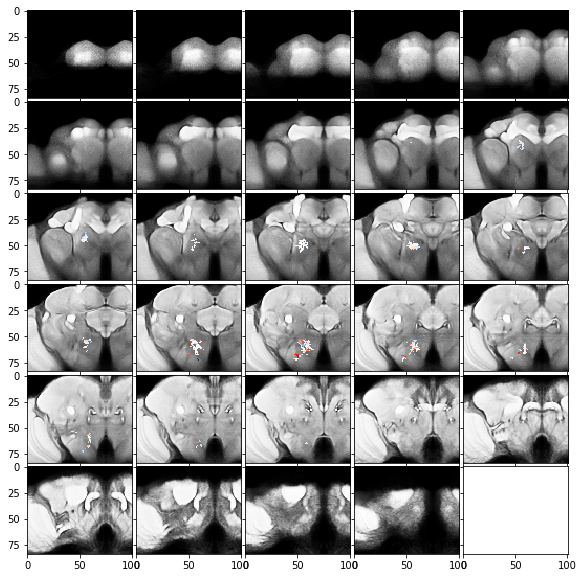

In [235]:
fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for z in range(29):
    grid[z].imshow(FDA_crop[:,:,z].T,cmap='Greys_r')
    grid[z].imshow(masked_times[:,:,z].T,cmap=mymap,vmin=end_c,vmax=start_c)

In [ ]:
plt.figure(figsize=(10,10))
#colors=['orange','pink','orange','b','g']
#plt.imshow(np.max(FDA_crop,axis=-1).T,cmap='Greys_r')

beh = 1
unique_crop_thresh = unique_crop[...,beh].copy()
unique_crop_thresh[unique_crop[...,beh]>=.01] =  1
unique_crop_thresh[unique_crop[...,beh]<.01] =  0
beh_mask = np.max(unique_crop_thresh[:,:,10:11],axis=-1)
#beh_mask = np.max(unique_crop_thresh[:,:,17:18],axis=-1)

beh_mask[beh_mask==0] = np.nan
plt.imshow(beh_mask.T,cmap='Reds',vmin=0,vmax=1)

for j,id_ in enumerate(all_):#[1355115431,1140245595,]):#,1747625772,1262360335,1664127054]):
    plt.subplot(5,4,j+1)
    plt.imshow(FDA_crop[:,:,10].T,cmap='Greys_r')
    out = skeletons[np.where(ids==id_)[0],:3]

    distance = (np.diff(out[:,0])**2 + np.diff(out[:,1])**2 + np.diff(out[:,2])**2)**.5
    bps = np.where(distance>4)[0]
    for i in range(len(bps)-1):
        xs = out[bps[i]+1:bps[i+1],0]/2.6
        ys = out[bps[i]+1:bps[i+1],1]/2.6
        xs -= start['x']
        ys -= start['y']

        plt.plot(xs,ys,color=colors[j],lw=.5)